# Importing necessary modules and data

In [ ]:
import keras
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from keras import backend as K

In [ ]:
train_data = datasets.CIFAR10("data", train=True, download=True)
test_data = datasets.CIFAR10("data", train=False, download=True)

100%|██████████| 170M/170M [00:10<00:00, 16.0MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
if torch.cuda.is_available():
    print("Using GPU, device name:", torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print("No GPU found, using CPU instead.")
    device = torch.device("cpu")

No GPU found, using CPU instead.


# Model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.fc2 = nn.Linear(256, 128)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc3 = nn.Linear(128, 10)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # conv1 -> relu -> pool
        x = self.pool(F.relu(self.conv2(x))) # conv2 -> relu -> pool
        x = self.pool(F.relu(self.conv3(x))) # conv3 -> relu -> pool

        x = x.view(-1, 128 * 4 * 4) # adjust dimensions to match fc1 input
        x = F.relu(self.fc1(x)) # fc1 -> relu
        x = F.relu(self.fc2(x)) # fc2 -> relu
        x = self.fc3(x) # fc3 -> output

        return x

## Model parameters

In [ ]:
learning_rate = 0.001
batch_size = 64
num_epochs = 30

## Set up data

In [ ]:
transform = transforms.ToTensor()

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_size = int(0.8 * len(train_dataset)) # 80% for training
val_size = len(train_dataset) - train_size # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training

In [ ]:
model = SimpleCNN()

loss_fun = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

min_epochs = 5
best_val_loss = float("inf")

train_loss = []
validation_loss = []

## Training with early stopping

In [ ]:
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimiser.zero_grad()
        output = model(data)
        loss = loss_fun(output, target)
        loss.backward()
        optimiser.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_loss.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    for data, target in val_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)

        loss = loss_fun(output, target)
        running_val_loss += loss.item()

        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    validation_loss.append(avg_val_loss)

    val_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs},"
          f"Train Loss: {avg_train_loss:.4f},"
          f"Validation Loss: {avg_val_loss:.4f},"
          f"Validation Accuracy: {val_accuracy:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= 5:
        print(f"Early stopping at epoch {epoch+1}")
        break


KeyboardInterrupt: 

## Training without early stopping (for the convergence graph)

In [ ]:
epochs_without_improvement = 0
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimiser.zero_grad()
        output = model(data)
        loss = loss_fun(output, target)
        loss.backward()
        optimiser.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_loss.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    for data, target in val_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)

        loss = loss_fun(output, target)
        running_val_loss += loss.item()

        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    validation_loss.append(avg_val_loss)

    val_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs},"
          f"Train Loss: {avg_train_loss:.4f},"
          f"Validation Loss: {avg_val_loss:.4f},"
          f"Validation Accuracy: {val_accuracy:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_without_improvement += 1

Epoch 1/15,Train Loss: 1.5843,Validation Loss: 1.3100,Validation Accuracy: 52.50%
Epoch 2/15,Train Loss: 1.1696,Validation Loss: 1.0538,Validation Accuracy: 62.92%
Epoch 3/15,Train Loss: 0.9671,Validation Loss: 0.9710,Validation Accuracy: 66.44%
Epoch 4/15,Train Loss: 0.8339,Validation Loss: 0.9560,Validation Accuracy: 66.92%
Epoch 5/15,Train Loss: 0.7217,Validation Loss: 0.8433,Validation Accuracy: 70.77%
Epoch 6/15,Train Loss: 0.6397,Validation Loss: 0.7747,Validation Accuracy: 73.27%
Epoch 7/15,Train Loss: 0.5512,Validation Loss: 0.7852,Validation Accuracy: 73.47%
Epoch 8/15,Train Loss: 0.4798,Validation Loss: 0.8012,Validation Accuracy: 73.84%
Epoch 9/15,Train Loss: 0.4006,Validation Loss: 0.8590,Validation Accuracy: 73.70%
Epoch 10/15,Train Loss: 0.3411,Validation Loss: 0.9221,Validation Accuracy: 72.95%
Epoch 11/15,Train Loss: 0.2845,Validation Loss: 0.9975,Validation Accuracy: 73.04%
Epoch 12/15,Train Loss: 0.2457,Validation Loss: 1.0184,Validation Accuracy: 73.12%
Epoch 13/15,T

## Convergence graph!

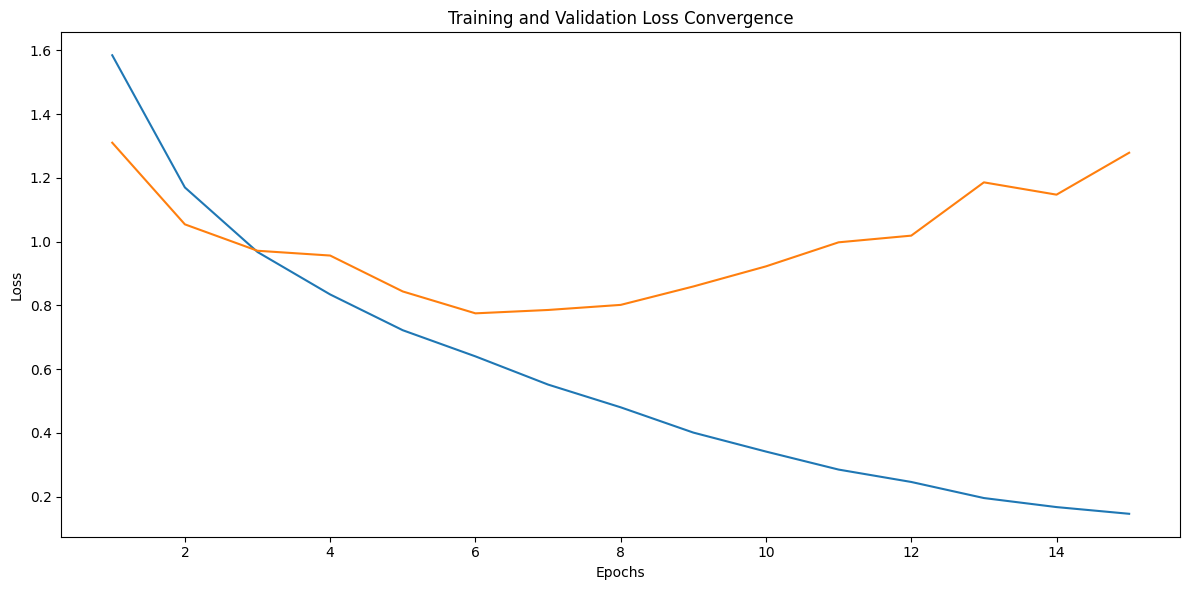

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(range(1, len(train_loss) + 1), train_loss)
plt.plot(range(1, len(validation_loss) + 1), validation_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Convergence")

plt.tight_layout()
plt.show()

# Batch normalisation

In [ ]:
class CNNWithBatchNorm(nn.Module):
    def __init__(self):
        super(CNNWithBatchNorm, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # conv1 -> bn -> relu -> pool
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) # conv2 -> bn -> relu -> pool
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) # conv3 -> bn -> relu -> pool

        x = x.view(-1, 128 * 4 * 4)

        x = F.relu(self.bn_fc1(self.fc1(x))) # fc1 -> bn -> relu
        x = F.relu(self.bn_fc2(self.fc2(x))) # fc2 -> bn -> relu
        x = self.fc3(x) # fc3 -> output

        return x

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:

                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

    return train_losses, val_losses

In [ ]:
model_with_bn = CNNWithBatchNorm().to(device)
model_without_bn = SimpleCNN().to(device)

In [ ]:
train_losses_bn, val_losses_bn = train_model(model_with_bn, train_loader, val_loader, num_epochs=15)

In [ ]:
train_losses_no_bn, val_losses_no_bn = train_model(model_without_bn, train_loader, val_loader, num_epochs=15)

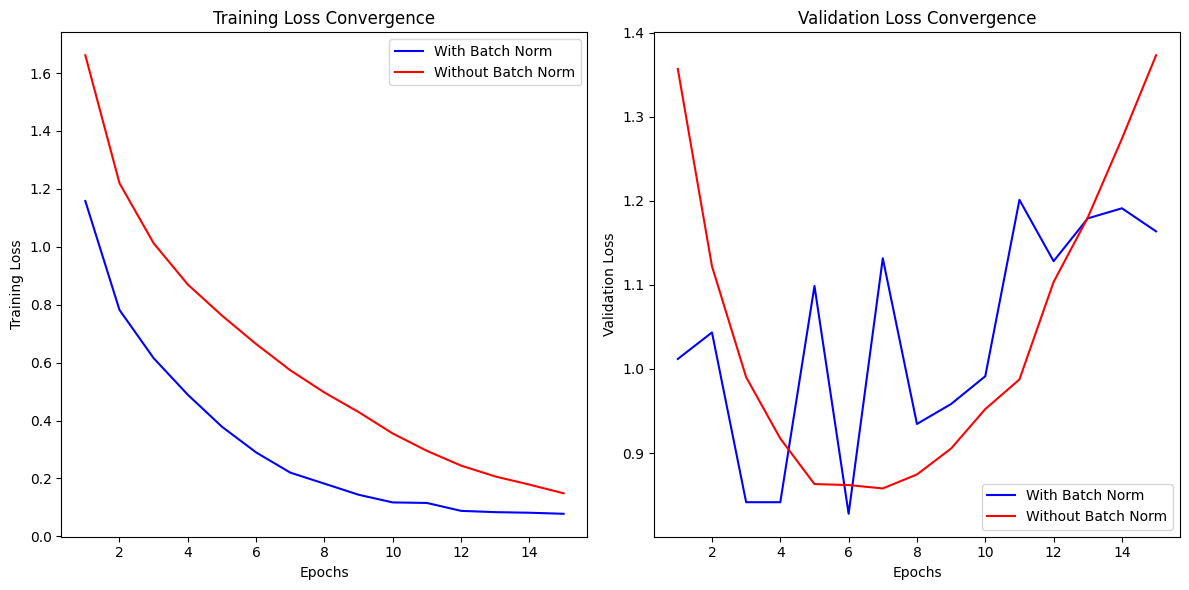

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_bn) + 1), train_losses_bn, label="With Batch Norm", color="blue")
plt.plot(range(1, len(train_losses_no_bn) + 1), train_losses_no_bn, label="Without Batch Norm", color="red")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Convergence")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_losses_bn) + 1), val_losses_bn, label="With Batch Norm", color="blue")
plt.plot(range(1, len(val_losses_no_bn) + 1), val_losses_no_bn, label="Without Batch Norm", color="red")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Convergence")
plt.legend()

plt.tight_layout()
plt.show()


# Visualising filters

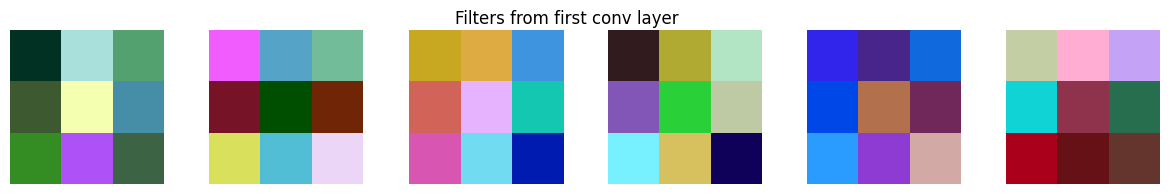

In [ ]:
def visualize_filters(layer, num_filters=6):
    filters = layer.weight.data.cpu()
    fig, axes = plt.subplots(1, num_filters, figsize=(15, 2))

    for i in range(num_filters):
        f = filters[i]
        f_min, f_max = f.min(), f.max()
        f = (f - f_min) / (f_max - f_min)

        axes[i].imshow(f.permute(1, 2, 0).numpy())
        axes[i].axis("off")

    plt.suptitle("Filters from first conv layer")
    plt.show()

visualize_filters(model_without_bn.conv1, num_filters=6)


In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_feature_maps(model, image):
    activations = []
    x = image
    hooks = []
    layer_names = ["conv1", "conv2", "conv3"]

    # I asked chat-gpt for a process for capturing the output of each layer during each pass however this code is my own
    # https://www.geeksforgeeks.org/what-are-pytorch-hooks-and-how-are-they-applied-in-neural-network-layers/
    def save_activation(name):
        def hook(model, input, output):
            activations.append((name, output.detach()))
        return hook

    for i, layer in enumerate(model.children()):
        if i in range(len(layer_names)):
            hook = layer.register_forward_hook(save_activation(layer_names[i]))
            hooks.append(hook)

    model(image)

    for hook in hooks:
        hook.remove()

    for layer_idx, feature_maps in activations:
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))

        for j in range(5):
            fmap = feature_maps[0, j, :, :]
            axes[j].imshow(fmap, cmap="viridis")
            axes[j].axis("off")

        plt.title(f"Feature Maps from Layer {layer_idx}")
        plt.show()


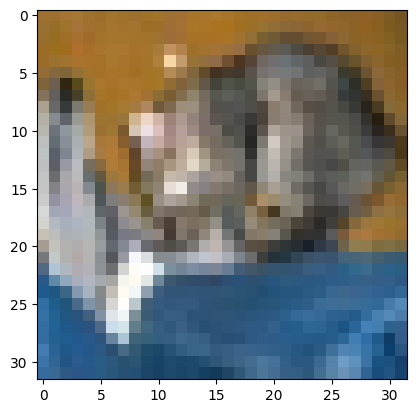

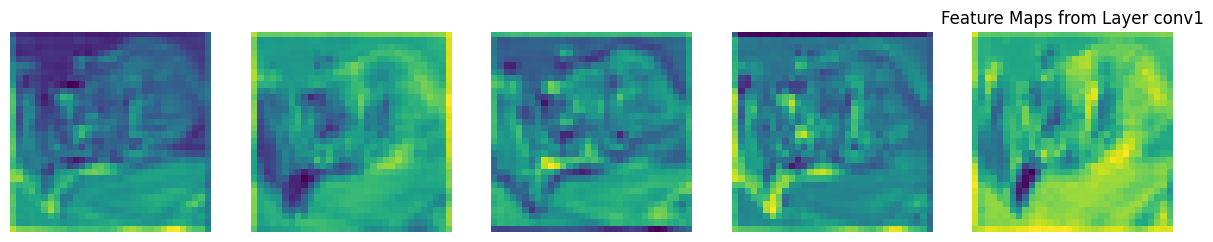

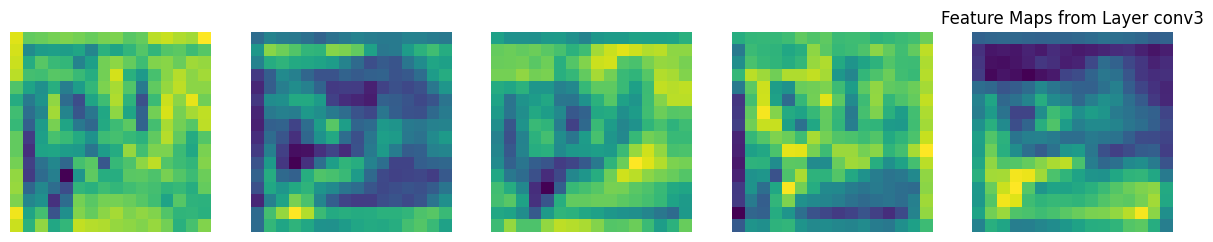

IndexError: too many indices for tensor of dimension 2

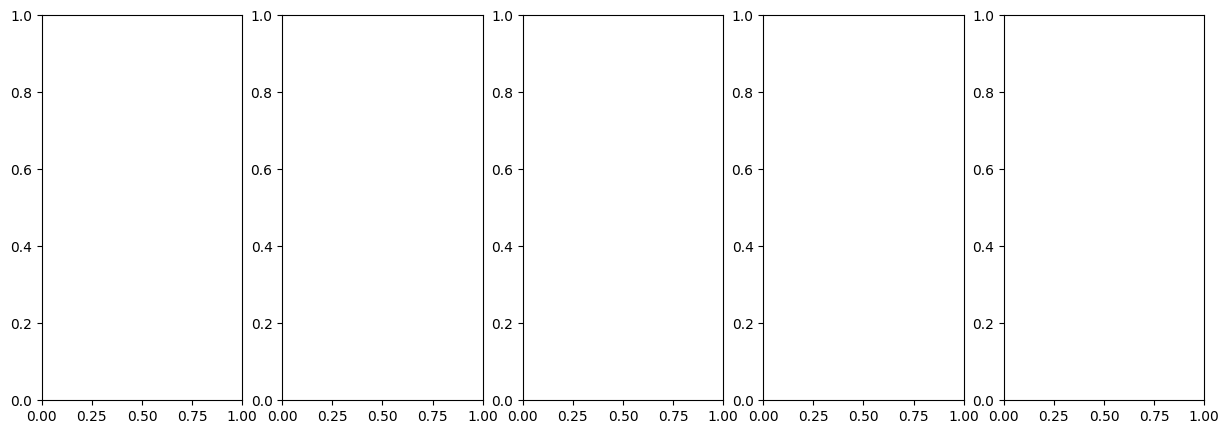

In [ ]:
test_image, _ = test_dataset[0]
plt.imshow(test_image.permute(1, 2, 0).numpy())
test_image = test_image.unsqueeze(0)

visualize_feature_maps(model_without_bn, test_image)